## Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Load Dataset

In [ ]:
df = pd.read_csv("df_full.csv")

In [ ]:
df.head()

user_id  age        isbn  rating  \
0        2   18  0195153448       0   
1        8   35  0002005018       5   
2        8   35  0060973129       0   
3        8   35  0374157065       0   
4        8   35  0393045218       0   

                                          book_title           book_author  \
0                                Classical Mythology    Mark P. O. Morford   
1                                       Clara Callan  Richard Bruce Wright   
2                               Decision in Normandy          Carlo D'Este   
3  Flu: The Story of the Great Influenza Pandemic...      Gina Bari Kolata   
4                             The Mummies of Urumchi       E. J. W. Barber   

   year_of_publication                publisher      city       state country  
0                 2002  Oxford University Press  stockton  california     usa  
1                 2001    HarperFlamingo Canada   timmins     ontario  canada  
2                 1991          HarperPerennial   timmins     ontario  canada  
3                 1999     Farrar Straus Giroux   timmins     ontario  canada  
4                 1999   W. W. Norton & Company   timmins     ontario  canada

## Examine the Dataset ISBNs

In [ ]:
df['isbn'].nunique()

267409

We have a very large amount of books, if we want to generate summaries of all, we might have to narrow down our dataset

## Examine the target variable "rating"

<Axes: >

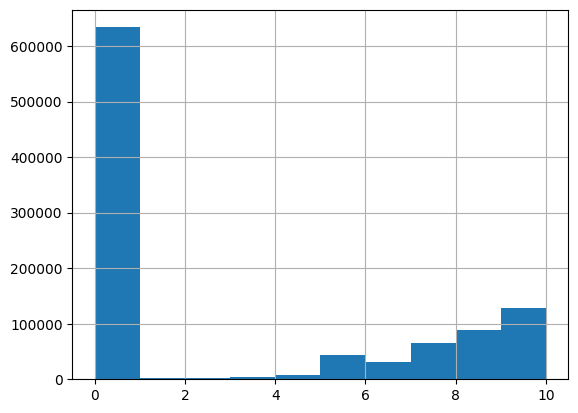

In [ ]:
df['rating'].hist()

In [ ]:
df['rating'].value_counts()

rating
0     633614
8      89324
10     69481
7      64593
9      59207
5      43909
6      30774
4       7394
3       4944
2       2299
1       1439
Name: count, dtype: int64

As we can see, there are a lot of ratings that are 0. A rating of 0 means that the user has not rated the item so we will remove these rows from the dataset

In [ ]:
df = df[df['rating'] != 0]
df['rating'].value_counts()

rating
8     89324
10    69481
7     64593
9     59207
5     43909
6     30774
4      7394
3      4944
2      2299
1      1439
Name: count, dtype: int64

In [ ]:
# Grab the 100 books with most reviews
most_rated_isbns = df["isbn"].value_counts().sort_values(ascending=False).head(100)
most_rated_isbns

isbn
0316666343    666
0971880107    576
0385504209    477
0312195516    366
0060928336    314
             ... 
0312305060    122
0380789019    122
068484477X    122
0590353403    118
0385505833    117
Name: count, Length: 100, dtype: int64

## Create Dataset with only the 100 books with most reviews

In [ ]:
# Grab the ISBNs and put them into a list
most_rated_isbns = most_rated_isbns.index.tolist()
len(most_rated_isbns)

100

In [ ]:
# Create a subset of the original dataset containing only reviews of the 100 selected books
df_most_rated_subset = df[df["isbn"].isin(most_rated_isbns)]
print(f"Shape: {df_most_rated_subset.shape}. Unique ISBNs: {df_most_rated_subset['isbn'].nunique()}")

Shape: (18279, 11). Unique ISBNs: 100


In [ ]:
# Grab only the attributes related to the BOOK/ITEM
most_rated_book_data = df_most_rated_subset[["isbn", "book_title", "book_author",  "year_of_publication", "publisher"]].drop_duplicates()
most_rated_book_data.shape

(100, 5)

In [ ]:
most_rated_book_data.head()

isbn                         book_title    book_author  \
42   0446310786              To Kill a Mockingbird     Harper Lee   
57   0440225701                  The Street Lawyer   JOHN GRISHAM   
122  0671027360                    Angels & Demons      Dan Brown   
141  0060976845  Little Altars Everywhere: A Novel  Rebecca Wells   
227  0316601950         The Pilot's Wife : A Novel   Anita Shreve   

     year_of_publication               publisher  
42                  1988  Little Brown & Company  
57                  1999                    Dell  
122                 2001             Pocket Star  
141                 1996               Perennial  
227                 1999          Back Bay Books

## Feed to CHAT GPT and Generate a 'Genre'  and 'Summary' Column

In [ ]:
summaries = [
    "A young girl witnesses racial prejudice and her father's fight for justice in the segregated South, learning powerful lessons about empathy, morality, and human nature.",
    "A wealthy lawyer's life changes after a hostage situation, leading him to uncover systemic corruption and fight for the marginalized, risking his career and personal safety.",
    "A symbologist races against time to decode ancient symbols and prevent a catastrophic plot involving the Illuminati and the Vatican, blending science, religion, and art.",
    "A Southern family’s interconnected stories reveal their struggles with love, secrets, and redemption, showcasing the strength and fragility of familial bonds and individual growth.",
    "A widow investigates her husband’s mysterious plane crash, uncovering secrets about his double life and grappling with betrayal, love, and her identity.",
    "A collection of essays detailing humorous personal experiences, cultural misunderstandings, and challenges in self-discovery, showcasing the absurdities of life with wit and heart.",
    "Through a young boy’s eyes, a summer unfolds on an Arkansas farm filled with secrets, conflicts, and life-altering events, painting a vivid picture of Southern life.",
    "The untold story of the Wicked Witch reimagines her as a misunderstood figure in a corrupt society, exploring themes of morality, power, and the fine line between good and evil.",
    "A runaway girl finds love and solace with three beekeeping sisters, learning about resilience, forgiveness, and family amidst the Civil Rights Movement.",
    "A man becomes a bodyguard for a mysterious god, entangling himself in a battle between ancient deities and modern beliefs in this epic tale of faith and myth.",
    "A young wizard uncovers a secret chamber at his magical school, confronting ancient forces, danger, and the dark history of the institution.",
    "A fugitive wizard stirs chaos, revealing hidden truths about loyalty, justice, and the young wizard’s past.",
    "A magical tournament tests courage, friendship, and wits as a young wizard faces sinister plots and mortal danger.",
    "A young orphan discovers his magical heritage and confronts an ancient evil threatening his new life.",
    "A woman overcomes trauma, heartbreak, and self-doubt, embarking on a journey of self-discovery and resilience.",
    "An alienated teenager navigates New York City, grappling with identity, innocence, and his transition into adulthood.",
    "A journalist immerses herself in low-wage jobs, exposing systemic poverty and the resilience of the working poor.",
    "A mysterious disappearance leaves survivors questioning faith, grappling with loss, and uncovering truths about the Rapture.",
    "A young nanny reveals the absurd and heartbreaking lives of Manhattan’s elite, navigating family chaos and personal growth.",
    "A harrowing account of a boy's resilience and courage as he endures unimaginable abuse and survives against the odds.",
    "A vampire recounts centuries of adventures, grappling with morality, identity, and immortality’s challenges.",
    "A woman navigates relationships, career, and self-discovery in a witty exploration of modern life.",
    "A pregnant teen abandoned at a Walmart finds a new family and inner strength.",
    "A murdered girl observes her family’s grief and healing from the afterlife, uncovering hidden truths.",
    "A symbologist deciphers religious art and puzzles to uncover a secret that shakes historical beliefs.",
    "A couple’s plan to skip Christmas leads to unexpected community bonding and festive chaos.",
    "A man moves to a remote Newfoundland town, uncovering family secrets while rediscovering his identity.",
    "Generations of a Nova Scotia family confront secrets, love, and betrayal in this sweeping saga.",
    "Women reconnect, exploring friendship and family as they uncover the truth about their pasts.",
    "A boy survives a shipwreck on a lifeboat with a tiger, exploring faith and resilience.",
    "A servant’s life changes forever when she becomes the muse of a famous painter, navigating love, art, and societal boundaries.",
    "A courtroom drama explores love, racial tensions, and war’s impact on a Pacific Northwest community.",
    "Chinese-American women and their mothers navigate cultural identity, family expectations, and the complexities of generational relationships.",
    "A man embarks on a spiritual journey in the Alaskan wilderness, confronting love, identity, and transformation.",
    "A compulsive shopper struggles with debt, relationships, and finding balance while humorously navigating her chaotic life.",
    "Dinah, a biblical figure, recounts her life and the women’s unique stories in her tribe, emphasizing female bonds and resilience.",
    "A missionary family’s experiences in Congo unravel secrets, guilt, and cultural misunderstandings, highlighting themes of redemption.",
    "A resourceful woman solves mysteries in Botswana, blending wit, wisdom, and compassion in her detective work.",
    "A small-town man grapples with his past, family, and dreams while uncovering secrets in a declining community.",
    "A young man raises his brother after their parents’ deaths, navigating life’s absurdities with humor and heartache.",
    "Two women explore decades of friendship, love, and betrayal through summer vacations, uncovering the intricacies of human connection.",
    "A young man’s affair with an older woman reveals a dark secret, exploring themes of love, shame, and justice.",
    "Modern researchers are sent to medieval France, facing unexpected dangers while unraveling mysteries of the past.",
    "A lawyer fakes his death and hides a fortune, but justice—and his conscience—catch up with him.",
    "A young man abandons societal norms to seek purpose in the Alaskan wilderness, confronting isolation and nature’s raw beauty.",
    "A journalist navigates heartbreak, family challenges, and self-discovery, blending humor with themes of resilience and growth.",
    "A young lawyer battles a powerful corporation in a legal battle for justice, uncovering corruption and greed.",
    "A harrowing firsthand account of a disastrous expedition on Mount Everest, revealing human endurance and frailty.",
    "Genetic experiments bring dinosaurs back to life in a park, leading to catastrophic consequences as science clashes with hubris.",
    "In a dystopian future, a firefighter questions his role in censoring knowledge, discovering the power of literature and rebellion.",
    "A man discovers how his life impacted others after his death, exploring interconnectedness and redemption.",
    "A professor and his former student discuss life’s most profound lessons during their final meetings.",
    "A father’s act of vengeance ignites a racially charged trial in the Deep South, testing morality.",
    "A law student uncovers a deadly conspiracy, drawing powerful enemies as she seeks to expose the truth.",
    "A centuries-old vampire recounts his experiences with love, betrayal, and the existential challenges of immortality.",
    "A boy wizard faces betrayal, loss, and rebellion as he confronts growing threats in the magical world.",
    "A timeless love story unfolds between a wealthy woman and a working-class man, spanning decades of devotion.",
    "A satirical critique of American politics, exposing societal inequalities and challenging conventional wisdom with sharp humor.",
    "A memoir of a boy’s impoverished Irish upbringing, marked by resilience, humor, and the pursuit of hope.",
    "Juror manipulation and courtroom drama converge in a thrilling battle between justice and corporate greed.",
    "Three imprisoned judges orchestrate elaborate cons while uncovering a scandal that could destroy powerful figures.",
    "A girl with Tourette's Syndrome navigates small-town prejudice, uncovering themes of acceptance and inner strength.",
    "A boy’s life is shaped by his friendship with a peculiar friend destined for greatness.",
    "Three women’s lives are connected through Virginia Woolf’s novel, exploring love, identity, and the passage of time.",
    "Four women solve crimes as part of a secret club, navigating murder mysteries and personal struggles.",
    "A young lawyer joins a prestigious firm, uncovering a sinister conspiracy that threatens his life and career.",
    "A boy survives poverty and hardship in 1930s Ireland, finding humor and hope amid despair.",
    "A billionaire’s surprising will sends a lawyer on a global journey, uncovering secrets and self-redemption.",
    "A rape survivor’s memoir explores trauma, resilience, and the pursuit of justice in the aftermath.",
    "An eviction battle escalates into tragedy, examining the collision of cultures and the cost of misunderstandings.",
    "A photographer and a housewife share an intense, fleeting love affair that changes their lives forever.",
    "A girl navigates foster care and self-discovery after her mother is imprisoned for murder.",
    "An investigator tracks a serial killer with the help of an imprisoned cannibalistic genius.",
    "A wounded Confederate soldier journeys home, encountering love and hardship in a haunting Civil War tale.",
    "A single woman humorously chronicles her misadventures in love, work, and self-improvement.",
    "A woman’s past resurfaces, threatening her present life and unraveling buried secrets.",
    "A family’s bond fractures after a tragedy, exploring forgiveness, love, and the resilience of the human spirit.",
    "A dwarf woman’s perspective offers insight into the lives of her German village during World War II.",
    "Scientists discover a mysterious underwater spacecraft, encountering psychological and physical challenges while unraveling its secrets.",
    "Two boys discover love, literature, and rebellion during China’s Cultural Revolution.",
    "A man discovers a hidden, magical London, navigating alliances and dangers to save an enigmatic girl.",
    "A young lawyer confronts his family’s dark past while defending his racist grandfather on death row.",
    "A boy witnesses a murder and must navigate threats while working with a determined lawyer.",
    "A high school romance unfolds, teaching lessons of faith, love, and loss.",
    "A law professor uncovers secrets about his deceased father’s mysterious fortune, facing danger and revelations.",
    "An exposé on the fast food industry’s impact on health, culture, and economic systems.",
    "A hobbit embarks on an epic adventure to reclaim treasure guarded by a dragon.",
    "A hostage crisis in South America brings together strangers, forming unexpected bonds through music and love.",
    "A woman becomes a bounty hunter, navigating danger and humor in her pursuit of justice.",
    "A girl and her horse recover from trauma with the help of a gifted horse trainer.",
    "A midwife faces a trial after a home birth tragedy, exploring ethics and personal responsibility.",
    "A grieving woman discovers a love letter and searches for its author, finding healing and romance.",
    "Three stories intertwine, exploring love, nature, and human connections in Appalachia.",
    "A group embarks on a quest to destroy a powerful ring, battling dark forces and inner struggles.",
    "Two boys sent to the countryside during China's Cultural Revolution discover forbidden literature, love, and storytelling.",
    "A mysterious spacecraft is discovered underwater, challenging a team’s perceptions of reality and human psychology.",
    "A dwarf woman chronicles her village’s lives during World War II, revealing resilience and humanity.",
    "A magical London beneath the surface unfolds as a man embarks on a dangerous quest to save a girl.",
    "A lawyer confronts his family’s racist history while defending his grandfather, a death row inmate.",
    "A boy witnesses a murder, becomes a target, and navigates threats with the help of a determined lawyer."
]

In [ ]:
genres = ['Literature',
 'Thriller',
 'Thriller',
 'Fiction',
 'Thriller',
 'Fiction',
 'Fiction',
 'Fantasy',
 'Fiction',
 'Fantasy',
 'Fantasy',
 'Fantasy',
 'Fantasy',
 'Fantasy',
 'Fantasy',
 'Fantasy',
 'Fiction',
 'Literature',
 'Non-fiction',
 'Science Fiction',
 'Fiction',
 'Non-fiction',
 'Fiction',
 'Romance',
 'Fiction',
 'Fiction',
 'Thriller',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Fiction',
 'Thriller',
 'Fiction',
 'Non-fiction',
 'Fiction',
 'Fiction',
 'Science Fiction',
 'Thriller',
 'Fiction',
 'Fiction',
 'Fiction',
 'Non-fiction',
 'Science Fiction',
 'Fantasy',
 'Science Fiction',
 'Fiction',
 'Non-fiction',
 'Thriller',
 'Thriller',
 'Fiction',
 'Fantasy',
 'Romance',
 'Fiction',
 'Fiction',
 'Non-fiction',
 'Thriller',
 'Thriller',
 'Fiction',
 'Fiction',
 'Fiction',
 'Thriller',
 'Thriller',
 'Non-fiction',
 'Fiction',
 'Non-fiction',
 'Fiction',
 'Romance',
 'Fiction',
 'Fiction',
 'Thriller',
 'Fiction',
 'Romance',
 'Fiction',
 'Fiction',
 'Fiction',
 'Science Fiction',
 'Fiction',
 'Fantasy',
 'Thriller',
 'Thriller',
 'Romance',
 'Fiction',
 'Non-fiction',
 'Fantasy',
 'Fiction',
 'Thriller',
 'Fiction',
 'Fiction',
 'Romance',
 'Fiction',
 'Fantasy']

In [ ]:
most_rated_book_data['genre'] = genres

In [ ]:
most_rated_book_data['summaries'] = summaries

In [ ]:
most_rated_book_data

isbn                                         book_title  \
42     0446310786                              To Kill a Mockingbird   
57     0440225701                                  The Street Lawyer   
122    0671027360                                    Angels & Demons   
141    0060976845                  Little Altars Everywhere: A Novel   
227    0316601950                         The Pilot's Wife : A Novel   
...           ...                                                ...   
13462  0440222656                                The Horse Whisperer   
15559  0375706771                                  Midwives: A Novel   
15701  0446606812                                Message in a Bottle   
19238  0060959037                           Prodigal Summer: A Novel   
58579  0345339703  The Fellowship of the Ring (The Lord of the Ri...   

              book_author  year_of_publication               publisher  \
42             Harper Lee                 1988  Little Brown & Company   
57           JOHN GRISHAM                 1999                    Dell   
122             Dan Brown                 2001             Pocket Star   
141         Rebecca Wells                 1996               Perennial   
227          Anita Shreve                 1999          Back Bay Books   
...                   ...                  ...                     ...   
13462      Nicholas Evans                 1996                    Dell   
15559     Chris Bohjalian                 1998                 Vintage   
15701     Nicholas Sparks                 1999           Warner Vision   
19238  Barbara Kingsolver                 2001               Perennial   
58579      J.R.R. TOLKIEN                 1986                 Del Rey   

            genre                                          summaries  
42     Literature  A young girl witnesses racial prejudice and he...  
57       Thriller  A wealthy lawyer's life changes after a hostag...  
122      Thriller  A symbologist races against time to decode anc...  
141       Fiction  A Southern family’s interconnected stories rev...  
227      Thriller  A widow investigates her husband’s mysterious ...  
...           ...                                                ...  
13462     Fiction  A mysterious spacecraft is discovered underwat...  
15559     Fiction  A dwarf woman chronicles her village’s lives d...  
15701     Romance  A magical London beneath the surface unfolds a...  
19238     Fiction  A lawyer confronts his family’s racist history...  
58579     Fantasy  A boy witnesses a murder, becomes a target, an...  

[100 rows x 7 columns]

## Merging with ratings dataset

In [ ]:
# Drop all features except isbn, genre and summary to merge dataset
most_rated_book_data_to_merge = most_rated_book_data.drop(columns=['book_title', 'book_author', 'year_of_publication', 'publisher'])
most_rated_book_data_to_merge.head()

isbn       genre                                          summaries
42   0446310786  Literature  A young girl witnesses racial prejudice and he...
57   0440225701    Thriller  A wealthy lawyer's life changes after a hostag...
122  0671027360    Thriller  A symbologist races against time to decode anc...
141  0060976845     Fiction  A Southern family’s interconnected stories rev...
227  0316601950    Thriller  A widow investigates her husband’s mysterious ...

In [ ]:
df_merged = pd.merge(df_most_rated_subset, most_rated_book_data_to_merge, on='isbn', how='inner')
df_merged.head()

user_id  age        isbn  rating                         book_title  \
0       26   35  0446310786      10              To Kill a Mockingbird   
1       51   34  0440225701       9                  The Street Lawyer   
2      114   57  0671027360      10                    Angels & Demons   
3      165   62  0060976845       9  Little Altars Everywhere: A Novel   
4      243   35  0316601950       9         The Pilot's Wife : A Novel   

     book_author  year_of_publication               publisher         city  \
0     Harper Lee                 1988  Little Brown & Company     bellevue   
1   JOHN GRISHAM                 1999                    Dell       renton   
2      Dan Brown                 2001             Pocket Star     ligonier   
3  Rebecca Wells                 1996               Perennial      olympia   
4   Anita Shreve                 1999          Back Bay Books  arden hills   

          state country       genre  \
0    washington     usa  Literature   
1    washington     usa    Thriller   
2  pennsylvania     usa    Thriller   
3    washington     usa     Fiction   
4     minnesota     usa    Thriller   

                                           summaries  
0  A young girl witnesses racial prejudice and he...  
1  A wealthy lawyer's life changes after a hostag...  
2  A symbologist races against time to decode anc...  
3  A Southern family’s interconnected stories rev...  
4  A widow investigates her husband’s mysterious ...

In [ ]:
df_merged.shape

(18279, 13)

## Generating a few more calculated columns

#### AVERAGE RATING BY GENRE

In [ ]:
average_rating_by_genre = df_merged.groupby('genre')['rating'].mean()
df_merged['Av. Rating by Genre'] = df_merged['genre'].map(average_rating_by_genre)
df_merged.head()

user_id  age        isbn  rating                         book_title  \
0       26   35  0446310786      10              To Kill a Mockingbird   
1       51   34  0440225701       9                  The Street Lawyer   
2      114   57  0671027360      10                    Angels & Demons   
3      165   62  0060976845       9  Little Altars Everywhere: A Novel   
4      243   35  0316601950       9         The Pilot's Wife : A Novel   

     book_author  year_of_publication               publisher         city  \
0     Harper Lee                 1988  Little Brown & Company     bellevue   
1   JOHN GRISHAM                 1999                    Dell       renton   
2      Dan Brown                 2001             Pocket Star     ligonier   
3  Rebecca Wells                 1996               Perennial      olympia   
4   Anita Shreve                 1999          Back Bay Books  arden hills   

          state country       genre  \
0    washington     usa  Literature   
1    washington     usa    Thriller   
2  pennsylvania     usa    Thriller   
3    washington     usa     Fiction   
4     minnesota     usa    Thriller   

                                           summaries  Av. Rating by Genre  
0  A young girl witnesses racial prejudice and he...             8.269058  
1  A wealthy lawyer's life changes after a hostag...             7.884856  
2  A symbologist races against time to decode anc...             7.884856  
3  A Southern family’s interconnected stories rev...             7.627164  
4  A widow investigates her husband’s mysterious ...             7.884856

#### AVERAGE RATING BY AUTHOR

In [ ]:
average_rating_by_author = df_merged.groupby('book_author')['rating'].mean()
df_merged['Av. Rating by Author'] = df_merged['book_author'].map(average_rating_by_author)
df_merged.head()

user_id  age        isbn  rating                         book_title  \
0       26   35  0446310786      10              To Kill a Mockingbird   
1       51   34  0440225701       9                  The Street Lawyer   
2      114   57  0671027360      10                    Angels & Demons   
3      165   62  0060976845       9  Little Altars Everywhere: A Novel   
4      243   35  0316601950       9         The Pilot's Wife : A Novel   

     book_author  year_of_publication               publisher         city  \
0     Harper Lee                 1988  Little Brown & Company     bellevue   
1   JOHN GRISHAM                 1999                    Dell       renton   
2      Dan Brown                 2001             Pocket Star     ligonier   
3  Rebecca Wells                 1996               Perennial      olympia   
4   Anita Shreve                 1999          Back Bay Books  arden hills   

          state country       genre  \
0    washington     usa  Literature   
1    washington     usa    Thriller   
2  pennsylvania     usa    Thriller   
3    washington     usa     Fiction   
4     minnesota     usa    Thriller   

                                           summaries  Av. Rating by Genre  \
0  A young girl witnesses racial prejudice and he...             8.269058   
1  A wealthy lawyer's life changes after a hostag...             7.884856   
2  A symbologist races against time to decode anc...             7.884856   
3  A Southern family’s interconnected stories rev...             7.627164   
4  A widow investigates her husband’s mysterious ...             7.884856   

   Av. Rating by Author  
0              8.966019  
1              7.687324  
2              8.296496  
3              7.768997  
4              7.511719

#### AVERAGE RATING BY YEAR OF PUBLICATION

In [ ]:
average_rating_by_year = df_merged.groupby('year_of_publication')['rating'].mean()
df_merged['Av. Rating by Year of Publication'] = df_merged['year_of_publication'].map(average_rating_by_year)
df_merged.head()

user_id  age        isbn  rating                         book_title  \
0       26   35  0446310786      10              To Kill a Mockingbird   
1       51   34  0440225701       9                  The Street Lawyer   
2      114   57  0671027360      10                    Angels & Demons   
3      165   62  0060976845       9  Little Altars Everywhere: A Novel   
4      243   35  0316601950       9         The Pilot's Wife : A Novel   

     book_author  year_of_publication               publisher         city  \
0     Harper Lee                 1988  Little Brown & Company     bellevue   
1   JOHN GRISHAM                 1999                    Dell       renton   
2      Dan Brown                 2001             Pocket Star     ligonier   
3  Rebecca Wells                 1996               Perennial      olympia   
4   Anita Shreve                 1999          Back Bay Books  arden hills   

          state country       genre  \
0    washington     usa  Literature   
1    washington     usa    Thriller   
2  pennsylvania     usa    Thriller   
3    washington     usa     Fiction   
4     minnesota     usa    Thriller   

                                           summaries  Av. Rating by Genre  \
0  A young girl witnesses racial prejudice and he...             8.269058   
1  A wealthy lawyer's life changes after a hostag...             7.884856   
2  A symbologist races against time to decode anc...             7.884856   
3  A Southern family’s interconnected stories rev...             7.627164   
4  A widow investigates her husband’s mysterious ...             7.884856   

   Av. Rating by Author  Av. Rating by Year of Publication  
0              8.966019                           8.375000  
1              7.687324                           7.958545  
2              8.296496                           7.820615  
3              7.768997                           7.630148  
4              7.511719                           7.958545

In [ ]:
df_merged.shape

(18279, 16)

## BUILDING THE MODEL

In order to build the model, we will be using a pipeline in order to preprocess the columns with different data types.
For the model we will be using a RandomForestRegressor from scikit-learn, as well as GridSearchCV for hyperparameter tuning.

In [ ]:
# Grab the different types of columns for preprocessing
numerical_cols = ['Av. Rating by Genre', 'Av. Rating by Author', 'Av. Rating by Year of Publication', 'year_of_publication']
categorical_cols = ['genre']
text_col = 'summaries'

In [ ]:
# Split the data into X and y
X = df_merged[numerical_cols + categorical_cols + [text_col]]
y = df_merged['rating']

In [ ]:
# Generate the train-test split using 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# One-hot encode the genres
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
# TF-IDF for the summaries
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
# Fit the TF-IDF to our data
tfidf_vectorizer.fit(X_train[text_col])

TfidfVectorizer(max_features=500, stop_words='english')

In [ ]:
'''
Here we are creating the preprocessor.
We are going to be scaling the numerical variables for optimal performance
We will also one-hot encode the genres column
Finally we will use the tfidf_vectorizer to process the text from the summaries column
'''
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', one_hot_encoder, categorical_cols),
        ('text', tfidf_vectorizer, text_col)
    ]
)

In [ ]:
# Create the pipeline consisting of the previously defined preprocessor followed by the RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [ ]:
# We can finally fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Av. Rating by Genre',
                                                   'Av. Rating by Author',
                                                   'Av. Rating by Year of '
                                                   'Publication',
                                                   'year_of_publication']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre']),
                                                 ('text',
                                                  TfidfVectorizer(max_features=500,
                                                                  stop_words='english'),
                                                  'summaries')])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np

y_pred = model.predict(X_test)

# Predictions
y_pred = model.predict(X_test)

# Regression Metrics
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Define relevance threshold
threshold = 5  # Ratings 5 or higher are considered "relevant"

# Binarize predictions and true values for classification metrics
y_pred_binary = (y_pred >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

# Classification Metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Print Results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Root Mean Squared Error (RMSE): 1.687981119497875
Mean Absolute Error (MAE): 1.319227490435906
Precision: 0.9617996604414262
Recall: 0.9849319037960012
F1-Score: 0.9732283464566929


We introduced a relevance threshold to evaluate the recommendation system using classification metrics like precision, recall, and F1-score. This approach measures how well the model identifies relevant items for users.

While these metrics initially showed very high values, this result is misleading because:

Ratings below the threshold like 1 and 4 are treated equally as "non-relevant" even though they convey very different levels of user satisfaction. This loss of granularity inflates metrics like precision.

As a result, we decided not to rely on these metrics, as they do not accurately reflect the nuanced preferences of users. Instead, we focused on regression metrics (RMSE and MAE) that evaluate the model's ability to predict ratings across the entire scale, providing a more precise understanding of user satisfaction.

# grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define the updated TF-IDF vectorizer with increased max_features
tfidf_vectorizer_updated = TfidfVectorizer(max_features=1000, stop_words='english')

# Update the preprocessor with the new TF-IDF settings
preprocessor_updated = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Av. Rating by Genre', 'Av. Rating by Author',
                                   'Av. Rating by Year of Publication', 'year_of_publication']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['genre']),
        ('text', tfidf_vectorizer_updated, 'summaries')
    ]
)

# Define the pipeline with RandomForestRegressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_updated),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_

# Predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Best Parameters:", grid_search.best_params_)
print(f"Mean Squared Error: {me}")
print(f"R-Squared: {r2}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Mean Squared Error: 2.8492802597812994
R-Squared: 0.18231737812609605


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np

# Define the updated TF-IDF vectorizer with increased max_features
tfidf_vectorizer_updated = TfidfVectorizer(max_features=1000, stop_words='english')

# Update the preprocessor with the new TF-IDF settings
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Av. Rating by Genre', 'Av. Rating by Author',
                                   'Av. Rating by Year of Publication', 'year_of_publication']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['genre']),
        ('text', tfidf_vectorizer_updated, 'summaries')
    ]
)

# Define the pipeline with the RandomForestRegressor
model_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=2,
        random_state=42
    ))
])

# Fit the model directly to the training data
model_pipeline_rf.fit(X_train, y_train)

# Predictions using the model
y_pred_rf = model_pipeline_rf.predict(X_test)

# Calculate regression metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Define the relevance threshold for classification metrics
threshold = 5

# Calculate binary classification metrics
y_pred_binary_rf = (y_pred_rf >= threshold).astype(int)
y_test_binary_rf = (y_test >= threshold).astype(int)

precision_rf = precision_score(y_test_binary_rf, y_pred_binary_rf)
recall_rf = recall_score(y_test_binary_rf, y_pred_binary_rf)
f1_rf = f1_score(y_test_binary_rf, y_pred_binary_rf)

# Display the results
print("Random Forest Results:")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1-Score: {f1_rf}")


Random Forest Results:
Root Mean Squared Error (RMSE): 1.687981119497875
Mean Absolute Error (MAE): 1.3144018722161608
Precision: 0.9617996604414262
Recall: 0.9849319037960012
F1-Score: 0.9732283464566929


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the updated TF-IDF vectorizer with increased max_features
tfidf_vectorizer_updated = TfidfVectorizer(max_features=1000, stop_words='english')

# Update the preprocessor with the new TF-IDF settings
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Av. Rating by Genre', 'Av. Rating by Author',
                                   'Av. Rating by Year of Publication', 'year_of_publication']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['genre']),
        ('text', tfidf_vectorizer_updated, 'summaries')
    ]
)

# Define the pipeline with XGBoost
model_pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define the grid for GridSearchCV
param_grid_xgb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=model_pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train)

# Extract the best model from GridSearch
best_model_xgb = grid_search_xgb.best_estimator_

# Use the best model for predictions
y_pred_xgb = best_model_xgb.predict(X_test)

# Calculate regression metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Define the relevance threshold for classification metrics
threshold = 5

# Calculate binary classification metrics
y_pred_binary_xgb = (y_pred_xgb >= threshold).astype(int)
y_test_binary_xgb = (y_test >= threshold).astype(int)

precision_xgb = precision_score(y_test_binary_xgb, y_pred_binary_xgb)
recall_xgb = recall_score(y_test_binary_xgb, y_pred_binary_xgb)
f1_xgb = f1_score(y_test_binary_xgb, y_pred_binary_xgb)

# Display the results
print("XGBoost Results:")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1-Score: {f1_xgb}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
XGBoost Results:
Root Mean Squared Error (RMSE): 1.6914750187293088
Mean Absolute Error (MAE): 1.3181032897085276
Precision: 0.9617996604414262
Recall: 0.9849319037960012
F1-Score: 0.9732283464566929


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from xgboost import XGBRegressor

# Load Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

# Step 1: Precompute Sentence-BERT embeddings
def compute_embeddings(texts, model, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        embeddings.extend(model.encode(batch, show_progress_bar=True))
    return np.array(embeddings)

# Compute embeddings for training and test data
X_train_sbert = compute_embeddings(X_train['summaries'].tolist(), sbert_model)
X_test_sbert = compute_embeddings(X_test['summaries'].tolist(), sbert_model)

# Step 2: Process categorical and numerical features
preprocessor_sbert = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Av. Rating by Genre', 'Av. Rating by Author',
                                   'Av. Rating by Year of Publication', 'year_of_publication']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['genre']),
    ]
)

# Transform the numerical and categorical features
X_train_structured = preprocessor_sbert.fit_transform(X_train.drop(columns=['summaries']))
X_test_structured = preprocessor_sbert.transform(X_test.drop(columns=['summaries']))

# Combine precomputed embeddings with structured data
X_train_combined = np.hstack([X_train_sbert, X_train_structured])
X_test_combined = np.hstack([X_test_sbert, X_test_structured])

# Step 3: Define the XGBoost model with predefined best parameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    random_state=42
)

# Step 4: Train the model
xgb_model.fit(X_train_combined, y_train)

# Step 5: Evaluate the model
y_pred_sbert = xgb_model.predict(X_test_combined)

# Calculate regression metrics
mse_sbert = mean_squared_error(y_test, y_pred_sbert)
rmse_sbert = np.sqrt(mse_sbert)
mae_sbert = mean_absolute_error(y_test, y_pred_sbert)

# Define the relevance threshold for classification metrics
threshold = 5

# Calculate binary classification metrics
y_pred_binary_sbert = (y_pred_sbert >= threshold).astype(int)
y_test_binary_sbert = (y_test >= threshold).astype(int)

precision_sbert = precision_score(y_test_binary_sbert, y_pred_binary_sbert)
recall_sbert = recall_score(y_test_binary_sbert, y_pred_binary_sbert)
f1_sbert = f1_score(y_test_binary_sbert, y_pred_binary_sbert)

# Display the results
print("XGBoost with Sentence-BERT Results:")
print(f"Root Mean Squared Error (RMSE): {rmse_sbert}")
print(f"Mean Absolute Error (MAE): {mae_sbert}")
print(f"Precision: {precision_sbert}")
print(f"Recall: {recall_sbert}")
print(f"F1-Score: {f1_sbert}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

XGBoost with Sentence-BERT Results:
Root Mean Squared Error (RMSE): 1.6940730796574512
Mean Absolute Error (MAE): 1.318798526241169
Precision: 0.9617996604414262
Recall: 0.9849319037960012
F1-Score: 0.9732283464566929


We switched from TF-IDF to BERT embeddings in some models to capture deeper, more meaningful representations of the text.

TF-IDF focuses on word frequency and importance but treats words independently, missing the context of how words relate to each other.
BERT embeddings, on the other hand, use advanced language models to understand the context and relationships between words, leading to richer and more accurate representations of the text.

Still we notice just complexity being introduced but no improvement.

NEURAL NETWORK ATTEMPT

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Reshape, concatenate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Preprocess structured data
preprocessor_gru = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Av. Rating by Genre', 'Av. Rating by Author',
                                   'Av. Rating by Year of Publication', 'year_of_publication']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['genre']),
    ]
)

X_train_structured_gru = preprocessor_gru.fit_transform(X_train.drop(columns=['summaries']))
X_test_structured_gru = preprocessor_gru.transform(X_test.drop(columns=['summaries']))

# Step 2: Define the GRU-based neural network
# Input for Sentence-BERT embeddings
embedding_input = Input(shape=(X_train_sbert.shape[1],), name='embedding_input')

# Reshape embeddings for GRU
embedding_reshaped = Reshape((X_train_sbert.shape[1], 1))(embedding_input)  # Add time dimension

# GRU layers
x1 = GRU(128, activation='relu', return_sequences=False)(embedding_reshaped)
x1 = Dropout(0.3)(x1)

# Input for structured data
structured_input = Input(shape=(X_train_structured_gru.shape[1],), name='structured_input')

# Dense layers for structured data
x2 = Dense(64, activation='relu')(structured_input)
x2 = Dropout(0.3)(x2)

# Combine both
combined = concatenate([x1, x2])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)

# Create the model
gru_model = Model(inputs=[embedding_input, structured_input], outputs=output)

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Step 3: Train the model
history_gru = gru_model.fit(
    [X_train_sbert, X_train_structured_gru],
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=2
)

# Step 4: Evaluate the model
y_pred_gru = gru_model.predict([X_test_sbert, X_test_structured_gru]).flatten()

# Calculate regression metrics
mse_gru = mean_squared_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)

# Define the relevance threshold for classification metrics
threshold = 5  # Ratings >= 5 are considered relevant

# Calculate binary classification metrics
y_pred_binary_gru = (y_pred_gru >= threshold).astype(int)
y_test_binary_gru = (y_test >= threshold).astype(int)

precision_gru = precision_score(y_test_binary_gru, y_pred_binary_gru)
recall_gru = recall_score(y_test_binary_gru, y_pred_binary_gru)
f1_gru = f1_score(y_test_binary_gru, y_pred_binary_gru)

# Display results
print("GRU-Based Neural Network Results:")
print(f"Root Mean Squared Error (RMSE): {rmse_gru}")
print(f"Mean Absolute Error (MAE): {mae_gru}")
print(f"Precision: {precision_gru}")
print(f"Recall: {recall_gru}")
print(f"F1-Score: {f1_gru}")


Epoch 1/10
366/366 - 24s - 66ms/step - loss: 685.5785 - mae: 6.5506 - val_loss: 5.7211 - val_mae: 1.9831
Epoch 2/10
366/366 - 35s - 95ms/step - loss: 5.6099 - mae: 1.8962 - val_loss: 3.0004 - val_mae: 1.3592
Epoch 3/10
366/366 - 20s - 56ms/step - loss: 4.8152 - mae: 1.7460 - val_loss: 2.8810 - val_mae: 1.3527
Epoch 4/10
366/366 - 16s - 45ms/step - loss: 4.5176 - mae: 1.6948 - val_loss: 2.8518 - val_mae: 1.3561
Epoch 5/10
366/366 - 20s - 54ms/step - loss: 4.3881 - mae: 1.6740 - val_loss: 2.8524 - val_mae: 1.3638
Epoch 6/10
366/366 - 16s - 43ms/step - loss: 4.3173 - mae: 1.6506 - val_loss: 2.7604 - val_mae: 1.3207
Epoch 7/10
366/366 - 21s - 56ms/step - loss: 4.1577 - mae: 1.6220 - val_loss: 2.8471 - val_mae: 1.3624
Epoch 8/10
366/366 - 20s - 56ms/step - loss: 4.1781 - mae: 1.6267 - val_loss: 2.7636 - val_mae: 1.2777
Epoch 9/10
366/366 - 20s - 56ms/step - loss: 4.0331 - mae: 1.5976 - val_loss: 2.7317 - val_mae: 1.3066
Epoch 10/10
366/366 - 21s - 57ms/step - loss: 3.9310 - mae: 1.5801 - va

# Simple Dense Neural Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Preprocess structured data
preprocessor_dense = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Av. Rating by Genre', 'Av. Rating by Author',
                                   'Av. Rating by Year of Publication', 'year_of_publication']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['genre']),
    ]
)

X_train_structured_dense = preprocessor_dense.fit_transform(X_train.drop(columns=['summaries']))
X_test_structured_dense = preprocessor_dense.transform(X_test.drop(columns=['summaries']))

# Step 2: Define the Dense-based neural network
# Input for Sentence-BERT embeddings
embedding_input = Input(shape=(X_train_sbert.shape[1],), name='embedding_input')

# Dense layers for embeddings
x1 = Dense(128, activation='relu')(embedding_input)
x1 = Dropout(0.3)(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.3)(x1)

# Input for structured data
structured_input = Input(shape=(X_train_structured_dense.shape[1],), name='structured_input')

# Dense layers for structured data
x2 = Dense(64, activation='relu')(structured_input)
x2 = Dropout(0.3)(x2)

# Combine both
combined = concatenate([x1, x2])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)

# Create the model
dense_model = Model(inputs=[embedding_input, structured_input], outputs=output)

# Compile the model
dense_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Step 3: Train the model
history_dense = dense_model.fit(
    [X_train_sbert, X_train_structured_dense],
    y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    verbose=2
)

# Step 4: Evaluate the model
y_pred_dense = dense_model.predict([X_test_sbert, X_test_structured_dense]).flatten()

# Calculate regression metrics
mse_dense = mean_squared_error(y_test, y_pred_dense)
rmse_dense = np.sqrt(mse_dense)
mae_dense = mean_absolute_error(y_test, y_pred_dense)

# Define the relevance threshold for classification metrics
threshold = 5  # Ratings >= 5 are considered relevant

# Calculate binary classification metrics
y_pred_binary_dense = (y_pred_dense >= threshold).astype(int)
y_test_binary_dense = (y_test >= threshold).astype(int)

precision_dense = precision_score(y_test_binary_dense, y_pred_binary_dense)
recall_dense = recall_score(y_test_binary_dense, y_pred_binary_dense)
f1_dense = f1_score(y_test_binary_dense, y_pred_binary_dense)

# Display results
print("Dense-Only Neural Network Results:")
print(f"Root Mean Squared Error (RMSE): {rmse_dense}")
print(f"Mean Absolute Error (MAE): {mae_dense}")
print(f"Precision: {precision_dense}")
print(f"Recall: {recall_dense}")
print(f"F1-Score: {f1_dense}")


Epoch 1/15
366/366 - 9s - 24ms/step - loss: 7.4644 - mae: 2.0813 - val_loss: 2.9424 - val_mae: 1.3820
Epoch 2/15
366/366 - 3s - 9ms/step - loss: 4.4099 - mae: 1.6719 - val_loss: 2.9559 - val_mae: 1.3800
Epoch 3/15
366/366 - 1s - 3ms/step - loss: 4.1627 - mae: 1.6234 - val_loss: 3.0861 - val_mae: 1.4432
Epoch 4/15
366/366 - 1s - 3ms/step - loss: 4.0656 - mae: 1.6027 - val_loss: 2.9740 - val_mae: 1.3998
Epoch 5/15
366/366 - 1s - 2ms/step - loss: 4.0264 - mae: 1.5929 - val_loss: 2.8279 - val_mae: 1.3395
Epoch 6/15
366/366 - 1s - 2ms/step - loss: 3.8827 - mae: 1.5627 - val_loss: 2.7812 - val_mae: 1.3060
Epoch 7/15
366/366 - 1s - 4ms/step - loss: 3.8103 - mae: 1.5522 - val_loss: 2.7765 - val_mae: 1.3242
Epoch 8/15
366/366 - 1s - 3ms/step - loss: 3.7631 - mae: 1.5419 - val_loss: 2.8804 - val_mae: 1.3565
Epoch 9/15
366/366 - 1s - 4ms/step - loss: 3.7345 - mae: 1.5372 - val_loss: 2.7880 - val_mae: 1.3312
Epoch 10/15
366/366 - 2s - 5ms/step - loss: 3.6439 - mae: 1.5117 - val_loss: 2.7450 - val_

# Table comparison metrics across models

In [ ]:
import pandas as pd

# Step 1: Create a dictionary with the metrics for each model
model_comparison = {
    "Model": ["Random Forest", "XGBoost", "Simple Neural Network"],
    "RMSE": [rmse_rf, rmse_xgb, rmse_dense],
    "Precision": [precision_rf, precision_xgb, precision_dense],
    "Recall": [recall_rf, recall_xgb, recall_dense],
    "F1-Score": [f1_rf, f1_xgb, f1_dense]
}

# Step 2: Convert the dictionary to a pandas DataFrame
comparison_table = pd.DataFrame(model_comparison)

print(comparison_table)

# Step 3: Display the table for comparison
#import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Table", dataframe=comparison_table)


                   Model      RMSE  Precision    Recall  F1-Score
0          Random Forest  1.687981     0.9618  0.984932  0.973228
1                XGBoost  1.691475     0.9618  0.984932  0.973228
2  Simple Neural Network  1.690236     0.9618  0.984932  0.973228


# linear regression

In [ ]:
# Step 4: Prepare a Linear Regression model for evaluation
from sklearn.linear_model import LinearRegression

# Combine embeddings and preprocessed structured data
X_train_combined_linear = np.hstack([X_train_sbert, X_train_structured])
X_test_combined_linear = np.hstack([X_test_sbert, X_test_structured])

# Create and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_combined_linear, y_train)

# Predictions using the Linear Regression model
y_pred_linear = linear_model.predict(X_test_combined_linear)

# Calculate regression metrics for Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

# Define the relevance threshold for classification metrics
y_pred_binary_linear = (y_pred_linear >= 5).astype(int)
y_test_binary_linear = (y_test >= 5).astype(int)

precision_linear = precision_score(y_test_binary_linear, y_pred_binary_linear)
recall_linear = recall_score(y_test_binary_linear, y_pred_binary_linear)
f1_linear = f1_score(y_test_binary_linear, y_pred_binary_linear)

# Display the Linear Regression results
print("Linear Regression Results:")
print(f"Root Mean Squared Error (RMSE): {rmse_linear}")
print(f"Mean Absolute Error (MAE): {mae_linear}")
print(f"Precision: {precision_linear}")
print(f"Recall: {recall_linear}")
print(f"F1-Score: {f1_linear}")


Linear Regression Results:
Root Mean Squared Error (RMSE): 1.724975780956504
Mean Absolute Error (MAE): 1.3409322651316768
Precision: 0.9617780294450736
Recall: 0.984352361634309
F1-Score: 0.9729342689388515


In [ ]:
import pandas as pd

# Step 1: Create a dictionary with the metrics for each model
model_comparison = {
    "Model": ["Random Forest", "XGBoost", "Simple Neural Network", "Linear Regression"],
    "RMSE": [rmse_rf, rmse_xgb, rmse_dense, rmse_linear],
    "Precision": [precision_rf, precision_xgb, precision_dense, precision_linear],
    "Recall": [recall_rf, recall_xgb, recall_dense, recall_linear],
    "F1-Score": [f1_rf, f1_xgb, f1_dense, f1_linear],

}

# Step 2: Convert the dictionary to a pandas DataFrame
comparison_table = pd.DataFrame(model_comparison)

print(comparison_table)

                   Model      RMSE  Precision    Recall  F1-Score
0          Random Forest  1.687981   0.961800  0.984932  0.973228
1                XGBoost  1.691475   0.961800  0.984932  0.973228
2  Simple Neural Network  1.690236   0.961800  0.984932  0.973228
3      Linear Regression  1.724976   0.961778  0.984352  0.972934


# Conclusion
The evaluation of various models, ranging from simple linear regressions to complex neural networks, revealed minimal differences in performance across the board. This consistency suggests that increasing model complexity does not contribute significantly to improving results in this context.

Given these findings, we conclude that the primary area for improvement lies not in model architecture but in the quality and structure of the data. Efforts should be directed toward enhancing the dataset by engineering additional features, exploring meaningful interactions between variables, and optimizing content-based recommendation strategies. These steps are expected to provide a stronger foundation for improving overall model performance and recommendation quality.*texto en cursiva*